In [ ]:
%pip install -r requirements.txt

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import ta
from vnstock3 import Vnstock
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

In [2]:
# Fetch stock data
stock = Vnstock().stock(symbol='FPT', source='VCI')
df = stock.quote.history(start='2014-01-01', end='2024-12-01', interval='1D')

2024-12-14 08:24:40 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [3]:
# Calculate technical indicators
df['price_range'] = df['high'] - df['low']
df['close_change'] = (df['close'] - df['open']) / df['open']
df['average_price'] = (df['high'] + df['low'] + df['close']) / 3
df['MA_5'] = df['close'].rolling(window=5).mean()
df['MA_20'] = df['close'].rolling(window=20).mean()
df['MA_50'] = df['close'].rolling(window=50).mean()
df['RSI'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()
bollinger = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
df['bollinger_high'] = bollinger.bollinger_hband()
df['bollinger_low'] = bollinger.bollinger_lband()
macd = ta.trend.MACD(close=df['close'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df['Ratio_Close_MA50'] = df['close'] / df['MA_50']
df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
df.dropna(subset=['Ratio_Close_MA50'], inplace=True)

In [4]:
# Label trends
df['next_close'] = df['close'].shift(-1)
df['trend'] = (df['next_close'] > df['close']).astype(int)
df.dropna(inplace=True)

In [5]:
# Select features and target variable
features = [
    'open', 'high', 'low', 'close', 'volume',
    'MA_5', 'MA_20', 'MA_50',
    'RSI', 'bollinger_high', 'bollinger_low',
    'MACD', 'MACD_signal'
]
X = df[features]
y = df['trend']

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Decision Tree model with Grid Search
param_grid = {
    'max_depth': [3],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
model = grid_search.best_estimator_

Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [8]:
# Predict on test set
y_pred = model.predict(X_test)

In [9]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

Model accuracy: 0.52


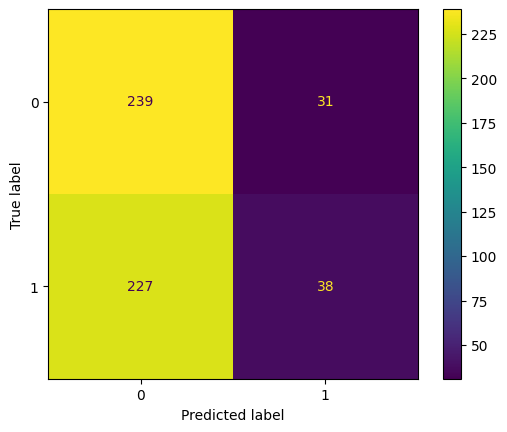

In [10]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

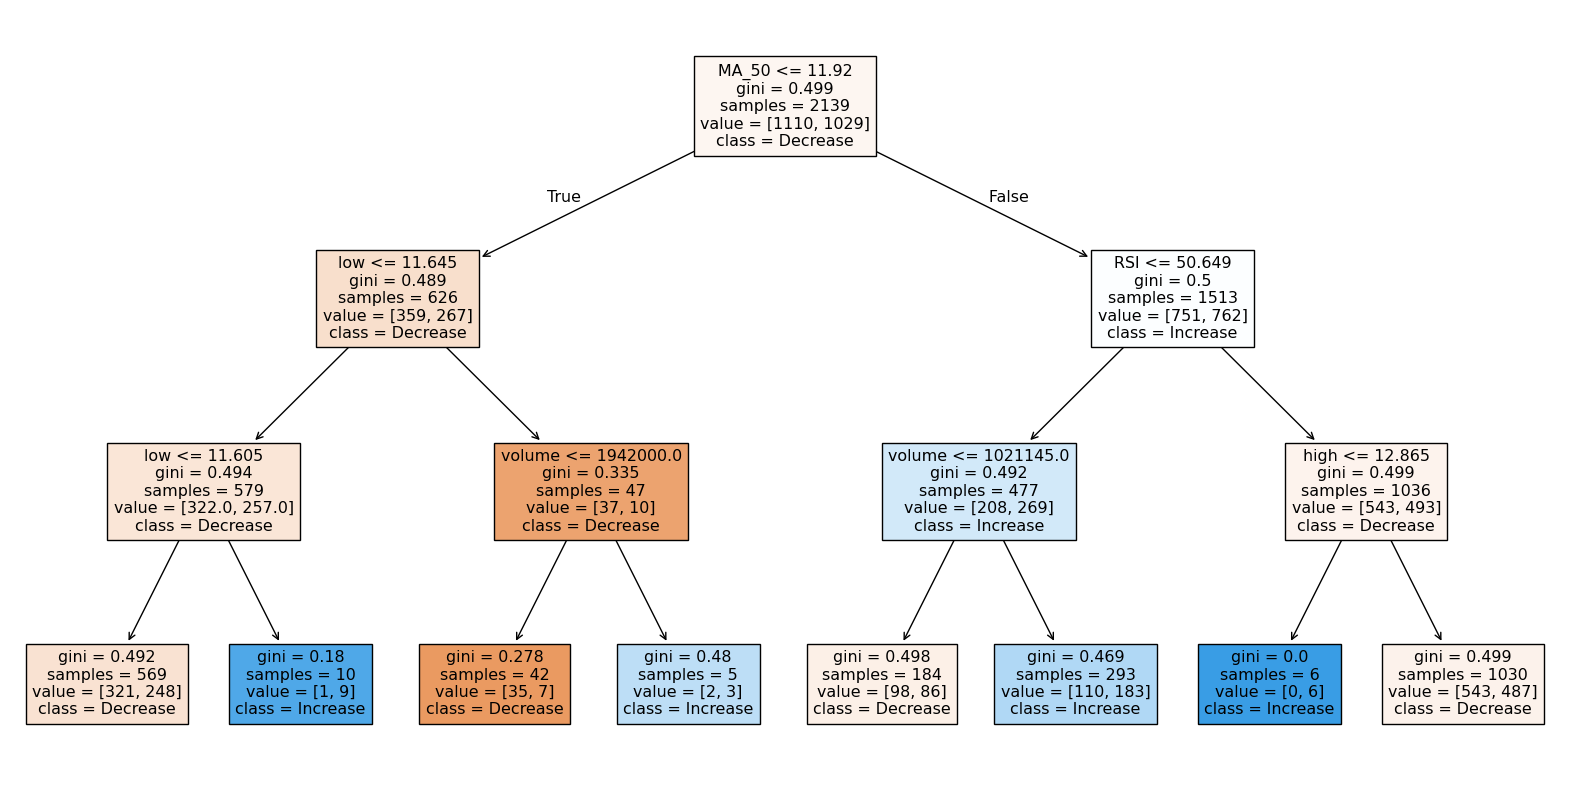

In [11]:
# Visualize decision tree
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=features, class_names=['Decrease', 'Increase'], filled=True)
plt.show()

In [25]:
# Cross-validation scores
scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores:", scores)

Cross-validation scores: [0.51588785 0.36448598 0.3682243  0.47102804 0.47752809]


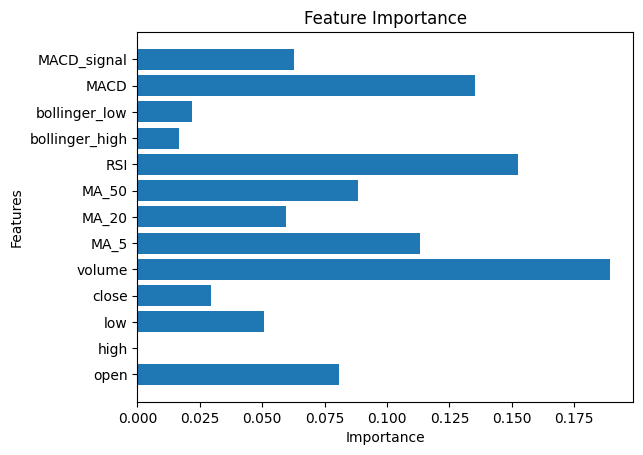

In [26]:
# Feature importance
importances = model.feature_importances_
plt.barh(features, importances)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

00:55:18 - cmdstanpy - INFO - Chain [1] start processing
00:55:19 - cmdstanpy - INFO - Chain [1] done processing


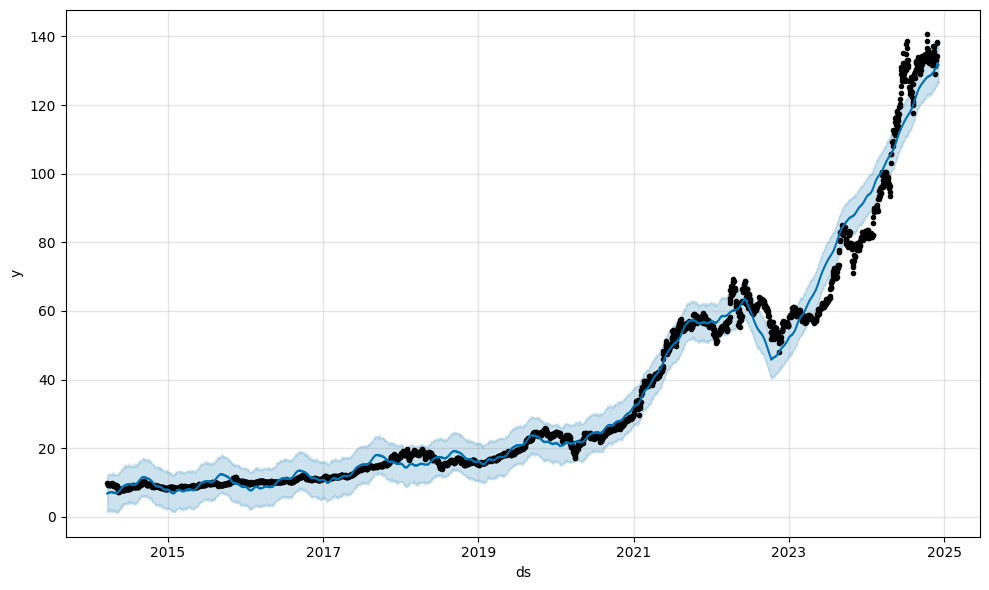

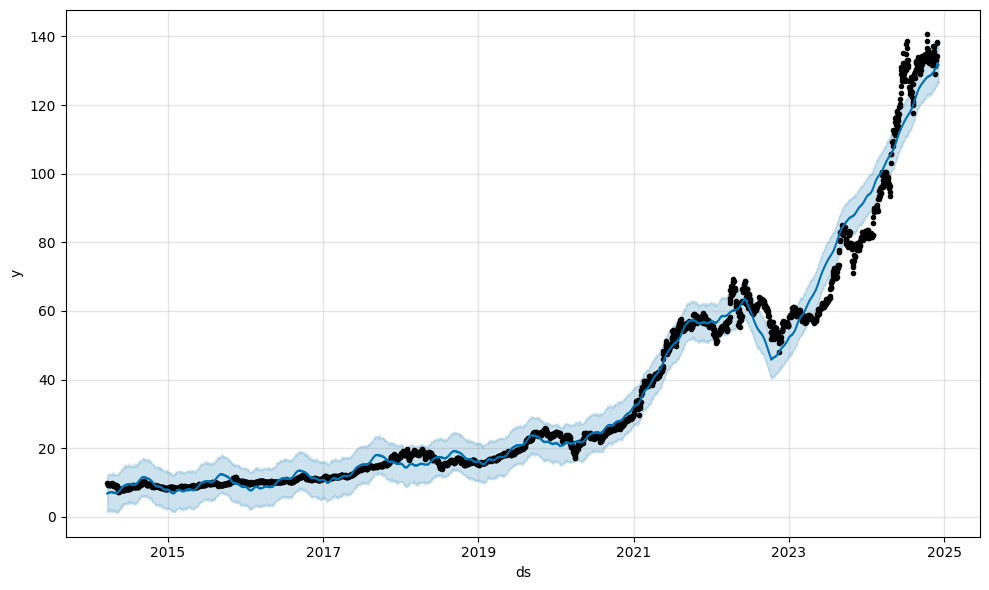

In [28]:
from prophet import Prophet

df_prophet = df.rename(columns={'close': 'y', 'time': 'ds'})
model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=7)  # Dự báo 7 ngày
forecast = model.predict(future)
model.plot(forecast)